# Read Data

In [153]:
import cPickle
import numpy as np

def unpickle(file):
    with open(file, 'rb') as fo:
        d = cPickle.load(fo)
    return d

def dict_merge(x, y):
    for key in x.keys():
        if key == 'data':
            x[key] = np.concatenate([x[key],y[key]])
        else:
            x[key] = x[key] + y[key]
            
raw_data_dict = unpickle("data/data_batch_1")
dict_merge(raw_data_dict, unpickle("data/data_batch_2"))
dict_merge(raw_data_dict, unpickle("data/data_batch_3"))
dict_merge(raw_data_dict, unpickle("data/data_batch_4"))
dict_merge(raw_data_dict, unpickle("data/data_batch_5"))
dict_merge(raw_data_dict, unpickle("data/test_batch"))

# Preprocess the data

In [154]:
data_dict = {}
for image, label in zip(raw_data_dict["data"], raw_data_dict["labels"]):
    if label not in data_dict:
        data_dict[label] = []
    data_dict[label].append(np.array(image))

# Print mean images

Label: 0


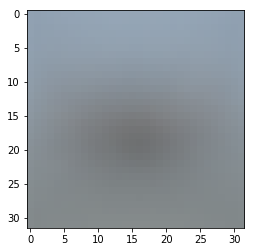

Label: 1


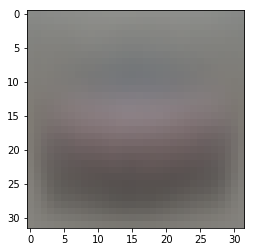

Label: 2


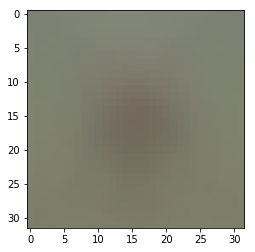

Label: 3


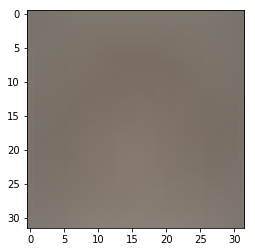

Label: 4


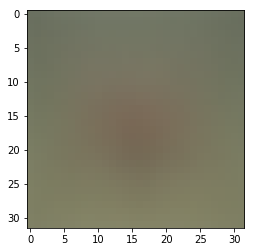

Label: 5


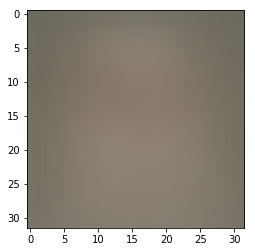

Label: 6


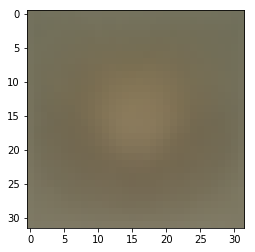

Label: 7


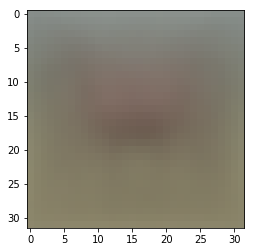

Label: 8


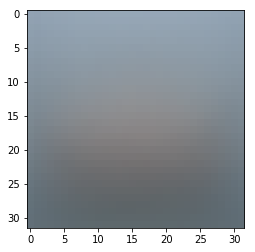

Label: 9


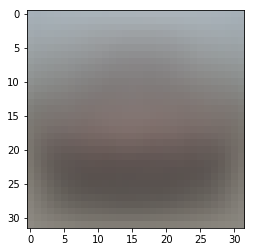

In [167]:
%matplotlib inline 

from matplotlib import pylab
from pylab import imshow, show, cm
from scipy.stats import norm
import cv2
import numpy as np

def view_image(image, label=""):
    """View a single image."""
    print("Label: %s" % label)
    imshow(image, interpolation='nearest')
    show()

def meanImage(data_dict):
    # return predicted labels of test set
    mean_image_dict = {}
    for label in range(10):
        mean_image_dict[label] = np.zeros(3072, dtype=np.float64)
        for image in data_dict[label]:
            mean_image_dict[label] = np.add(mean_image_dict[label], image)
        mean_image_dict[label] /= (len(data_dict[label]))
        #img_R = mean_image_dict[label][0:1024].reshape((32, 32))
        #img_G = mean_image_dict[label][1024:2048].reshape((32, 32))
        #img_B = mean_image_dict[label][2048:3072].reshape((32, 32))
        #mean_image_dict[label] = np.dstack((img_R, img_G, img_B))
        mean_image = mean_image_dict[label].astype("uint8")
        mean_image = np.transpose(np.reshape(mean_image,(3, 32, 32)), (1, 2, 0))
        view_image(mean_image, label=label)
    return mean_image_dict

mean_image_dict = meanImage(data_dict)

# Part A

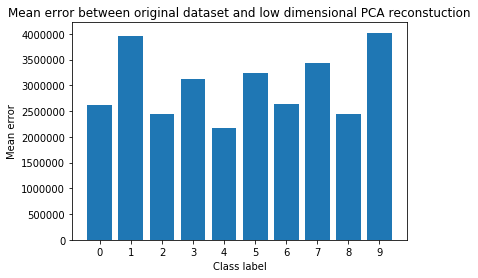

In [175]:
%matplotlib inline 

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt

pca_dict = {}
for label in data_dict:
    pca = PCA(n_components=20)
    pca_transform = pca.fit_transform(data_dict[label])
    pca_dict[label] = pca.inverse_transform(pca_transform)
    
#for label in pca_dict:
 #   for image in pca_dict[label]:
  #      p = np.transpose(np.reshape(pca_dict[label],(3, 32, 32)), (1, 2, 0))
   #     view_image(p, label=label)

error_dict = {}
for label in range(10):
    error = 0
    for d_img, pca_img in zip(data_dict[label], pca_dict[label]):
        error += np.linalg.norm(d_img - pca_img)**2 #euclidean_distances(d_img, pca_img)**2
    error_dict[label] = error / float(len(data_dict[label]))

# Plot bar graph of errors
bar_plt = plt.bar(np.arange(10), error_dict.values())
plt.xlabel('Class label')
plt.ylabel('Mean error')
plt.title('Mean error between original dataset and low dimensional PCA reconstuction')
plt.xticks(np.arange(10))
plt.show()

# Part B

In [170]:
# compute distance matrix between mean images 
square_distance_mat = []
for i in range(10):
    row = []
    for j in range(10):
        row.append(np.linalg.norm(mean_image_dict[i] - mean_image_dict[j])**2)
    square_distance_mat.append(row)
np.savetxt("partb_distances.csv", square_distance_mat, delimiter=",", comments='')     

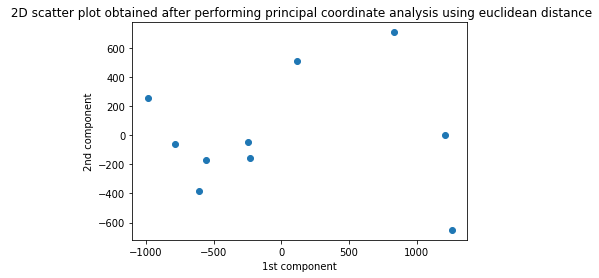

In [176]:
%matplotlib inline 

def eigenDecomposition(covmat):
    eigenValues, eigenVectors = np.linalg.eig(covmat)
    eigenValues = np.array(map(abs, eigenValues))
    idx = eigenValues.argsort()[::-1]   
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenValues, eigenVectors

def principal_coordinate_analysis(D_square):
    s = 2
    A = np.identity(10) - 0.1 * np.ones((10,10))
    W = -0.5 * np.dot(np.dot(A, D_square), A.T)
    eigenValues, eigenVectors = eigenDecomposition(W)
    eigenValueMatrix = np.sqrt(np.diag(eigenValues[:s]))
    Us = eigenVectors[:,:s]
    Y = np.dot(Us, eigenValueMatrix)
    return Y

Y = principal_coordinate_analysis(square_distance_mat)
plt.scatter(Y[:,0], Y[:,1])
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.title(' 2D scatter plot obtained after performing principal coordinate analysis using euclidean distance')
plt.show()